### Importing Library

imports essential libraries for data processing, visualization, machine learning, and deep learning tasks.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

### Loading and Inspecting the Dataset

loads a CSV file containing the fake reviews dataset and displays the first few rows of the data.



In [2]:
data = pd.read_csv('/kaggle/input/fake-reviews-dataset/fake reviews dataset.csv')

data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [3]:
print(f"The shape of the data: {data.shape }")

The shape of the data: (40432, 4)


In [4]:
data['category'].value_counts().reset_index()

,category,count
0,Kindle_Store_5,4730
1,Books_5,4370
2,Pet_Supplies_5,4254
3,Home_and_Kitchen_5,4056
4,Electronics_5,3988
5,Sports_and_Outdoors_5,3946
6,Tools_and_Home_Improvement_5,3858
7,Clothing_Shoes_and_Jewelry_5,3848
8,Toys_and_Games_5,3794
9,Movies_and_TV_5,3588


<Axes: xlabel='label', ylabel='count'>

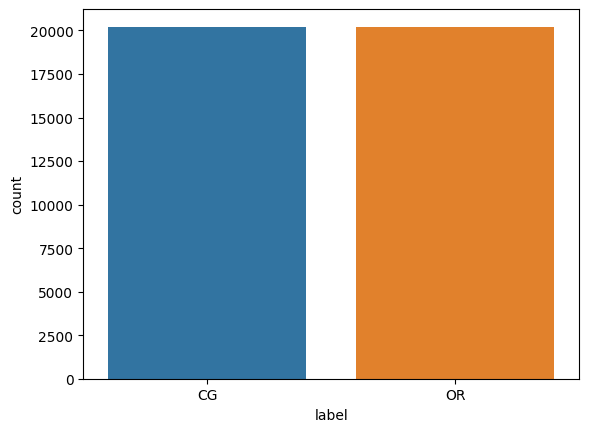

In [5]:
sns.countplot(x='label', data=data)

In [6]:
data.drop(columns=['category', 'rating'], inplace= True)

In [7]:
data.head()

,label,text_
0,CG,"Love this! Well made, sturdy, and very comfor..."
1,CG,"love it, a great upgrade from the original. I..."
2,CG,This pillow saved my back. I love the look and...
3,CG,"Missing information on how to use it, but it i..."
4,CG,Very nice set. Good quality. We have had the s...


In [8]:
label_map = {
    'CG': 1,
    'OR': 0
}

data['label'] = data['label'].map(label_map)
data.head()

,label,text_
0,1,"Love this! Well made, sturdy, and very comfor..."
1,1,"love it, a great upgrade from the original. I..."
2,1,This pillow saved my back. I love the look and...
3,1,"Missing information on how to use it, but it i..."
4,1,Very nice set. Good quality. We have had the s...


In [9]:
data['label'].value_counts()

label
1    20216
0    20216
Name: count, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   40432 non-null  int64 
 1   text_   40432 non-null  object
dtypes: int64(1), object(1)
memory usage: 631.9+ KB


### Checking for GPU Availability in TensorFlow

In [11]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


### Checking for GPU Availability in PyTorch

In [12]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Loading Pretrained BERT Model for Sequence Classification

* BertForSequenceClassification.from_pretrained("bert-base-uncased", ...): This method loads a pre-trained BERT model with the following configurations:

    * **"bert-base-uncased"**: The identifier for the base, uncased version of BERT.
    * **num_labels=2:** Specifies that the model will output two labels, suitable for binary classification tasks.
    * **output_attentions=False:** Ensures the model does not return attention weights during forward passes.
    * **output_hidden_states=False:** Prevents the model from returning hidden states from intermediate layers.
* BertTokenizer.from_pretrained("bert-base-uncased"): Loads the corresponding tokenizer for BERT, which will convert input text into tokens that the BERT model understands.

In [13]:
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer, AdamW
)

# BERT
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                                num_labels = 2,                             
                                                                output_attentions = False, 
                                                                output_hidden_states = False 
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model.cuda()


print(' Base models loaded')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

 Base models loaded


In [14]:
sentences = data['text_'].values
labels = data['label'].values
data['text_'][10]

"As advertised. 5th one I've had. The only problem is that it's not really a"

In [15]:
print('Original: ', sentences[0])
print('Tokenized BERT: ', bert_tokenizer.tokenize(sentences[0]))
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sentences[0])))

Original:  Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty
Tokenized BERT:  ['love', 'this', '!', 'well', 'made', ',', 'sturdy', ',', 'and', 'very', 'comfortable', '.', 'i', 'love', 'it', '!', 'very', 'pretty']
Token IDs BERT:  [2293, 2023, 999, 2092, 2081, 1010, 23073, 1010, 1998, 2200, 6625, 1012, 1045, 2293, 2009, 999, 2200, 3492]


In [16]:
sequence = """Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️"""

bert_tokenized_sequence = bert_tokenizer.tokenize(sequence)

print("""Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️""")
print("BERT:", bert_tokenized_sequence)

Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️
BERT: ['will', 'your', 'hometown', 'be', 'taking', 'in', 'obama', '’', 's', 'refugees', '?', 'here', '’', 's', 'the', 'list', 'of', 'cities', 'where', 'they', '’', 're', 'being', 'transplant', '##ed', '[UNK]']


## Code to Tokenize Sentences with BERT

This code snippet demonstrates how to tokenize a list of sentences using BERT's tokenizer from the Hugging Face Transformers library. The sentences are padded, truncated, and converted into input IDs suitable for feeding into a BERT model.


In [17]:
bert_input_ids = []
bert_attention_masks = []
sentence_ids = []
counter = 0

for sent in sentences:
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                           # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = 512,              # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
 
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    sentence_ids.append(counter)
    counter  = counter + 1
    
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

print('Original: ', sentences[1])
print('Token IDs BERT:', bert_input_ids[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  love it, a great upgrade from the original.  I've had mine for a couple of years
Token IDs BERT: tensor([  101,  2293,  2009,  1010,  1037,  2307, 12200,  2013,  1996,  2434,
         1012,  1045,  1005,  2310,  2018,  3067,  2005,  1037,  3232,  1997,
         2086,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0

## Code to Create a TensorDataset from BERT Inputs

This code snippet demonstrates how to combine tokenized BERT inputs and labels into a PyTorch `TensorDataset` and set a global seed for reproducibility.



In [18]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)

## Code to Remove Index from TensorDataset and Recreate a New Dataset

This code snippet defines a function `index_remover` that extracts the tokenized input IDs, attention masks, and labels from a `TensorDataset`, removes the index, and returns a new `TensorDataset`. It also demonstrates how to use this function to create a new dataset from an existing one.


In [19]:
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset
        
trial_dataset =  index_remover(bert_dataset)
trial_dataset[0]

(tensor([  101,  2293,  2023,   999,  2092,  2081,  1010, 23073,  1010,  1998,
          2200,  6625,  1012,  1045,  2293,  2009,   999,  2200,  3492,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

## Code to Split Dataset into Train, Validation, and Test Sets

This code snippet demonstrates how to split a BERT dataset into training, validation, and test sets. It also calculates and prints the number of samples in each set, as well as the number of samples with a specific label (e.g., "real disaster tweets").



In [20]:
train_size = int(0.9 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

bert_train_dataset, bert_val_dataset = random_split(bert_dataset, [train_size, val_size])

train_size = int(0.9 * len(bert_train_dataset))
test_size = len(bert_train_dataset) - train_size

bert_train_dataset, bert_test_dataset = random_split(bert_train_dataset, [train_size, test_size])

sentence_ids_list_valid = []
for a,b,c,d in bert_val_dataset:
  sentence_ids_list_valid.append(a.tolist())

bert_train_dataset = index_remover(bert_train_dataset)
bert_val_dataset = index_remover(bert_val_dataset)
bert_test_dataset = index_remover(bert_test_dataset)

label_temp_list = []
for a,b,c in bert_train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with real fake review'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c in bert_val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with real fake review'.format(sum(label_temp_list)))

label_temp_list = []
for a,b,c in bert_test_dataset:
  label_temp_list.append(c)

print('{:>5,} test samples'.format(test_size))
print('{:>5,} test samples with real fake review'.format(sum(label_temp_list)))

32,749 training samples
16,407 training samples with real fake review
4,044 validation samples
2,011 validation samples with real fake review
3,639 test samples
1,798 test samples with real fake review


## Code to Create DataLoaders for Training, Validation, and Test Sets

This code snippet demonstrates how to create DataLoaders for the training, validation, and test datasets. It uses PyTorch's `DataLoader` class along with `RandomSampler` for shuffling the training data and `SequentialSampler` for sequentially sampling validation and test data.



In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10
 
bert_train_dataloader = DataLoader(
            bert_train_dataset,  
            sampler = RandomSampler(bert_train_dataset),
            batch_size = batch_size
        )

bert_validation_dataloader = DataLoader(
            bert_val_dataset, 
            sampler = SequentialSampler(bert_val_dataset), 
            batch_size = batch_size
        )

bert_test_dataloader = DataLoader(
            bert_test_dataset, 
            sampler = SequentialSampler(bert_test_dataset), 
            batch_size = batch_size
        )


In [22]:
bert_optimizer = AdamW(bert_model.parameters(), lr = 5e-5, eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(bert_train_dataloader) * epochs

bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

bert_training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    bert_model.train()

    for step, batch in enumerate(bert_train_dataloader):

        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        bert_model.zero_grad()        

        outputs = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs[0] 
        logits = outputs[1]
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        bert_optimizer.step()

        bert_scheduler.step()

    avg_train_loss = total_train_loss / len(bert_train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    bert_model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in bert_validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0] 
        logits = outputs[1]
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(bert_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(bert_validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    bert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...
  Batch   100  of  3,275.    Elapsed: 0:00:58.
  Batch   200  of  3,275.    Elapsed: 0:01:56.
  Batch   300  of  3,275.    Elapsed: 0:02:54.
  Batch   400  of  3,275.    Elapsed: 0:03:53.
  Batch   500  of  3,275.    Elapsed: 0:04:51.
  Batch   600  of  3,275.    Elapsed: 0:05:49.
  Batch   700  of  3,275.    Elapsed: 0:06:47.
  Batch   800  of  3,275.    Elapsed: 0:07:45.
  Batch   900  of  3,275.    Elapsed: 0:08:44.
  Batch 1,000  of  3,275.    Elapsed: 0:09:42.
  Batch 1,100  of  3,275.    Elapsed: 0:10:40.
  Batch 1,200  of  3,275.    Elapsed: 0:11:38.
  Batch 1,300  of  3,275.    Elapsed: 0:12:37.
  Batch 1,400  of  3,275.    Elapsed: 0:13:35.
  Batch 1,500  of  3,275.    Elapsed: 0:14:33.
  Batch 1,600  of  3,275.    Elapsed: 0:15:32.
  Batch 1,700  of  3,275.    Elapsed: 0:16:30.
  Batch 1,800  of  3,275.    Elapsed: 0:17:28.
  Batch 1,900  of  3,275.    Elapsed: 0:18:27.
  Batch 2,000  of  3,275.    Elapsed: 0:19:25.
  Batch 2,100  of

In [27]:
import pandas as pd

# pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=bert_training_stats)

df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.145535,0.185425,0.960988,0:31:49,0:01:04
2,0.054943,0.062502,0.983704,0:31:53,0:01:04
3,0.021471,0.169087,0.971358,0:31:55,0:01:04
4,0.009589,0.159398,0.975309,0:31:56,0:01:04
5,0.003531,0.136303,0.977531,0:31:55,0:01:04


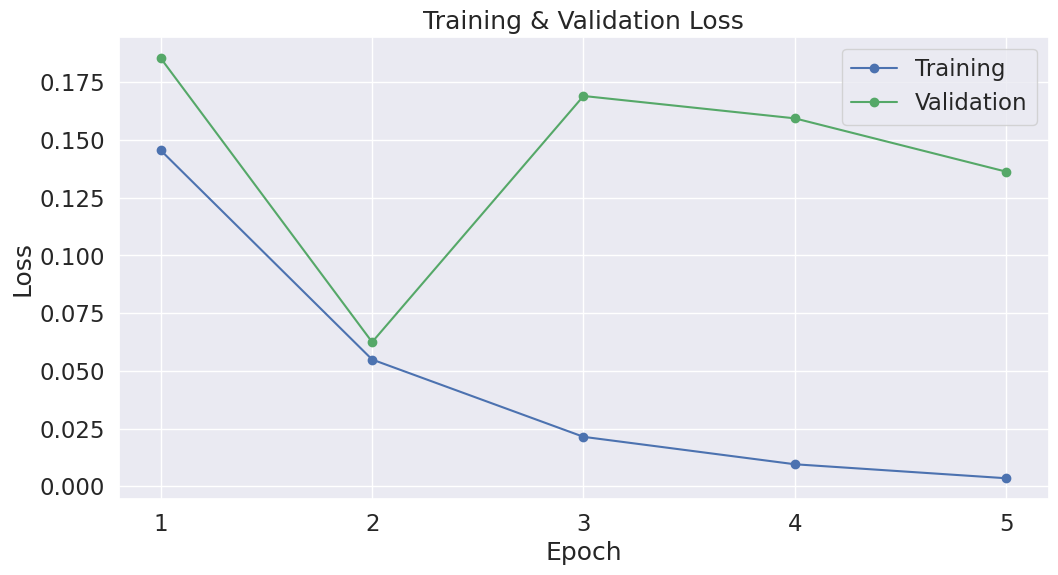

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

In [29]:
bert_model.eval()
predictions , true_labels = [], []

# Predict 
for batch in bert_test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bert_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE!')

DONE!


In [30]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

matthews_set = []
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [31]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "matthews_corrcoef": mcc,
        "true positive": tp,
        "ture negative": tn,
        "false positive": fp,
        "false negative": fn
    }
get_eval_report(flat_true_labels, flat_predictions)

{'matthews_corrcoef': 0.9529253489025813,
 'true positive': 1790,
 'ture negative': 1762,
 'false positive': 79,
 'false negative': 8}

In [32]:
from sklearn.metrics import classification_report 

print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1841
           1       0.96      1.00      0.98      1798

    accuracy                           0.98      3639
   macro avg       0.98      0.98      0.98      3639
weighted avg       0.98      0.98      0.98      3639

